# Vega Lite Examples in Haskell - Multi-View Displays

The overview notebook - `VegaLiteGallery` - describes how 
[`hvega`](http://hackage.haskell.org/package/hvega)
is used to create Vega-Lite visualizations.

-----

## Table of Contents

This notebook represents the [Multi-View DIsplays](https://vega.github.io/vega-lite/examples/#multi-vire-displays)
section of the [Vega-Lite example gallery](https://vega.github.io/vega-lite/examples/).

### Faceting: Trellis Plot or Small Multiples

 - [Trellis Bar Chart](#Trellis-Bar-Chart)
 - [Trellis Stacked Bar Chart](#Trellis-Stacked-Bar-Chart)
 - [Trellis Scatter Plot](#Trellis-Scatter-Plot)
 - [Trellis Histograms](#Trellis-Histograms)
 - [Trellis Scatter Plot Showing Anscombe's Quartet](#Trellis-Scatter-Plot-Showing-Anscombe's-Quartet)
 - [Becker's Barley Trellis Plot](#Becker's-Barley-Trellis-Plot)
 - [Trellis Area](#Trellis-Area)
 
### Repeat and Concatenation

 - [Repeat and Layer to Show Different Weather Measures](#Repeat-and-Layer-to-Show-Different-Weather-Measures)
 - [Vertical Concatenation](#Vertical-Concatenation)
 - [Horizontally Repeated Charts](#Horizontally-Repeated-Charts)
 - Interactive Scatterplot Matrix (repeat of version in the Interactive notebook)
 - [Marginal Histograms](#Marginal-Histograms)
 - [Discretizing Scales](#Discretizing-Scales)
 - [Nested View Concatenation Aligned with Axis minExtent](#Nested-View-Concatenation-Aligned-with-Axis-minExtent)
 - [Population Pyramid](#Population-Pyramid)

---

## Versions

The notebook was last run with the following versions of [`hvega`](https://hackage.haskell.org/package/hvega) and
related modules:

In [1]:
:!ghc-pkg latest ghc
:!ghc-pkg latest ihaskell
:!ghc-pkg latest hvega
:!ghc-pkg latest ihaskell-hvega

ghc-8.4.4

ihaskell-0.9.1.0

hvega-0.4.0.0

ihaskell-hvega-0.2.0.3

As to when it was last run, how about:

In [2]:
import Data.Time (getCurrentTime)
getCurrentTime

2019-09-04 13:07:23.858487737 UTC

## Set up

See the overview notebook for an explanation of this section (it provides code I use to compare the `hvega` output
to the specification given in the Vega-Lite gallery).

In [3]:
{-# LANGUAGE OverloadedStrings #-}

-- VegaLite uses these names
import Prelude hiding (filter, lookup, repeat)

import Graphics.Vega.VegaLite

-- IHaskell automatically imports this if the `ihaskell-vega` module is installed
-- import IHaskell.Display.Hvega

-- If you are viewing this in an IHaskell notebook rather than Jupyter Lab,
-- use the following to see the visualizations
--
-- vlShow = id

In [4]:
{-# LANGUAGE QuasiQuotes #-}

import qualified Data.ByteString.Lazy.Char8 as BL8
import qualified Data.HashMap.Strict as HM
import qualified Data.Set as S

import Data.Aeson (Value(Object), encode)
import Data.Aeson.QQ.Simple (aesonQQ)
import Control.Monad (forM_, unless, when)
import Data.Maybe (fromJust)
import System.Directory (removeFile)
import System.Process (readProcess, readProcessWithExitCode)

validate ::
  VLSpec       -- ^ The expected specification
  -> VegaLite  -- ^ The actual visualization
  -> IO ()
validate exp vl = 
  let got = fromVL vl
      put = putStrLn
  in if got == exp
      then put "Okay"
      else do
        let red = "\x1b[31m"
            def = "\x1b[0m"
            
            report m = put (red ++ m ++ def)
            
        report "The visualization and expected specification do not match."
        
        -- assume both objects
        let Object oexp = exp
            Object ogot = got
            kexp = S.fromList (HM.keys oexp)
            kgot = S.fromList (HM.keys ogot)
            kmiss = S.toList (S.difference kexp kgot)
            kextra = S.toList (S.difference kgot kexp)
            keys = S.toList (S.intersection kexp kgot)
            
        unless (null kmiss && null kextra) $ do
          put ""
          report "Keys are different:"
          unless (null kmiss)  $ put ("  Missing: " ++ show kmiss)
          unless (null kextra) $ put ("  Extra  : " ++ show kextra)

        -- this often creates an impressive amount of text for what is
        -- only a small change, which is why it is followed by a call
        -- to debug
        --
        forM_ keys $ \key ->
          let vexp = fromJust (HM.lookup key oexp)
              vgot = fromJust (HM.lookup key ogot)
          in when (vexp /= vgot) $ do
            put ""
            report ("Values are different for " ++ show key)
            put ("  Expected: " ++ show vexp)
            put ("  Found   : " ++ show vgot)
          
        putStrLn ""
        report "The field-level differences are:"
        debug_ exp vl


-- Rather than come up with a way to diff JSON here, rely on `jq` and the trusty
-- `diff` command. This is not written to be robust!
--
debug_ spec vl = do
  let tostr = BL8.unpack . encode
  
  expected <- readProcess "jq" [] (tostr spec)
  got <- readProcess "jq" [] (tostr (fromVL vl))

  let f1 = "expected.json"
      f2 = "got.json"
      
  writeFile f1 expected
  writeFile f2 got
  
  let diffOpts = ["--minimal", f1, f2]
  (_, diff, _) <- readProcessWithExitCode "diff" diffOpts ""
  putStrLn diff
  
  forM_ [f1, f2] removeFile

-----

## Faceting: Trellis Plot or Small Multiples

 - [Trellis Bar Chart](#Trellis-Bar-Chart)
 - [Trellis Stacked Bar Chart](#Trellis-Stacked-Bar-Chart)
 - [Trellis Scatter Plot](#Trellis-Scatter-Plot)
 - [Trellis Histograms](#Trellis-Histograms)
 - [Trellis Scatter Plot Showing Anscombe's Quartet](#Trellis-Scatter-Plot-Showing-Anscombe's-Quartet)
 - [Becker's Barley Trellis Plot](#Becker's-Barley-Trellis-Plot)
 - [Trellis Area](#Trellis-Area)
 
---

### Trellis Bar Chart

From https://vega.github.io/vega-lite/examples/trellis_bar.html

I have removed the ``"width": {"step": 17}`` setting from the specification, and instead added
``"scale": {"rangeStep": 17}`` to the X-axis encoding, to match the version used in the
[Vega editor](https://vega.github.io/editor/#/examples/vega-lite/trellis_bar).

In [5]:
trellisBarSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "A trellis bar chart showing the US population distribution of age groups and gender in 2000.",
  "data": { "url": "data/population.json"},
  "transform": [
    {"filter": "datum.year == 2000"},
    {"calculate": "datum.sex == 2 ? 'Female' : 'Male'", "as": "gender"}
  ],
  "mark": "bar",
  "encoding": {
    "row": {"field": "gender", "type": "nominal"},
    "y": {
      "aggregate": "sum", "field": "people", "type": "quantitative",
      "axis": {"title": "population"}
    },
    "x": {"field": "age", "type": "ordinal", "scale": {"rangeStep":  17}},
    "color": {
      "field": "gender", "type": "nominal",
      "scale": {"range": ["#EA98D2", "#659CCA"]}
    }
  }
}
|]

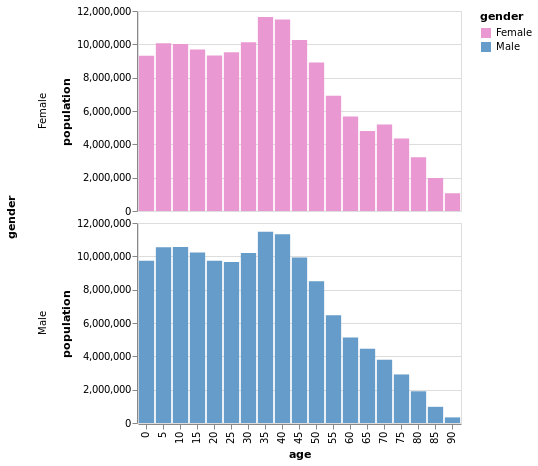

In [6]:
trellisBar =
    let desc = description "A trellis bar chart showing the US population distribution of age groups and gender in 2000."
        dvals = dataFromUrl "data/population.json" []
        
        trans = transform
                  . filter (FExpr "datum.year == 2000")
                  . calculateAs "datum.sex == 2 ? 'Female' : 'Male'" "gender"
                
        colRange = SRange (RStrings ["#EA98D2", "#659CCA"])
        enc = encoding
                . row [FName "gender", FmType Nominal]
                . position Y [PAggregate Sum, PName "people", PmType Quantitative, PAxis [AxTitle "population"]]
                . position X [PName "age", PmType Ordinal, PScale [SRangeStep (Just 17)]]
                . color [MName "gender", MmType Nominal, MScale [colRange]]
                
    in toVegaLite [desc, dvals, trans [], mark Bar [], enc []]
    
vlShow trellisBar

In [7]:
validate trellisBarSpec trellisBar

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Trellis Stacked Bar Chart

From https://vega.github.io/vega-lite/examples/trellis_stacked_bar.html

In [8]:
trellisStackedBarSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/barley.json"},
  "mark": "bar",
  "encoding": {
    "column": {"field": "year", "type": "ordinal"},
    "x": {"field": "yield", "type": "quantitative", "aggregate": "sum"},
    "y": {"field": "variety", "type": "nominal"},
    "color": {"field": "site", "type": "nominal"}
  }
}
|]

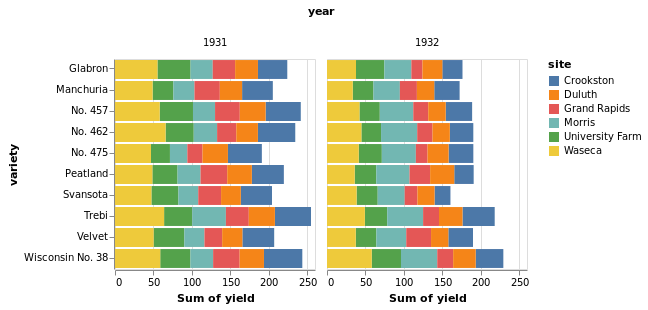

In [9]:
trellisStackedBar =
    let dvals = dataFromUrl "data/barley.json" []
    
        enc = encoding
                . column [FName "year", FmType Ordinal]
                . position X [PName "yield", PmType Quantitative, PAggregate Sum]
                . position Y [PName "variety", PmType Nominal]
                . color [MName "site", MmType Nominal]
                
    in toVegaLite [dvals, mark Bar [], enc []]
    
vlShow trellisStackedBar

In [10]:
validate trellisStackedBarSpec trellisStackedBar

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Trellis Scatter Plot

From https://vega.github.io/vega-lite/examples/trellis_scatter.html

The specification comes from the [Vega Editor](https://vega.github.io/editor/#/examples/vega-lite/trellis_scatter)
rather than that given on the page above (it is slightly different). However, it still can not be created
directly in `hvega`, but the same visualization can be created: see https://github.com/gicentre/elm-vegalite/issues/5
for more discussion about encoding faceted plots.

In [11]:
trellisScatterSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/movies.json"},
  "mark": "point",
  "columns": 2,
  "encoding": {
    "facet": {"field": "MPAA_Rating", "type": "ordinal"},
    "x": {"field": "Worldwide_Gross", "type": "quantitative"},
    "y": {"field": "US_DVD_Sales", "type": "quantitative"}
  }
}
|]

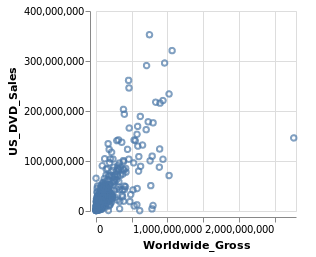

In [12]:
trellisScatter =
    let dvals = dataFromUrl "data/movies.json" []
        enc = encoding
                . position X [PName "Worldwide_Gross", PmType Quantitative]
                . position Y [PName "US_DVD_Sales", PmType Quantitative]
        
    in toVegaLite [ dvals
                  , columns 2
                  , facetFlow [FName "MPAA_Rating", FmType Ordinal]
                  , specification (asSpec [mark Point [], enc []])
                  ]
    
vlShow trellisScatter

Although the specification is rather different, as shown below, and the output above may not match
the Vega-Lite gallery, it does 
[display correctly in the Vega Editor](https://vega.github.io/editor/#/url/vega-lite/N4KABGBEAmCGAutIC4zEgVwE4BsVTkQHoBbAewDcBLAUwGcA6AKzrIDtIAaKAMzKxIJ86eAE8ADjXyQW7SAF95ncFDqSAxsJURIgrAGtp4slTbwu2qDTbqy0UwHMtEF1AAewyD1o5o0gOr8vgDuVNA0APoA4lhkdHRcUGKS0gCOGLBmVIjwVBRSSpY6op7eNL7SAKoAyhEAIgBqdRHVsDj0iZDJUqiQ6Zm5OXkFlvIqhToAJHTqABY0gtKz8PDidMhERPkOsAwO2bMYAEYMVGREM-OCWzQ7ALQ42TRbAMzMrBzKOrY4GCRsCVQACYvrxYOoaOZUOgyhVegBZAAKAEFkREAEoIRydbrSfj2NhtBSgyC2NjeJzQsbyIA).

In [13]:
validate trellisScatterSpec trellisScatter

The visualization and expected specification do not match.

Keys are different:
  Missing: ["encoding","mark"]
  Extra  : ["facet","spec"]

The field-level differences are:
2d1
<   "mark": "point",
5a5,17
>   "spec": {
>     "mark": "point",
>     "encoding": {
>       "x": {
>         "field": "Worldwide_Gross",
>         "type": "quantitative"
>       },
>       "y": {
>         "field": "US_DVD_Sales",
>         "type": "quantitative"
>       }
>     }
>   },
8,20c20,22
<   "encoding": {
<     "facet": {
<       "field": "MPAA_Rating",
<       "type": "ordinal"
<     },
<     "x": {
<       "field": "Worldwide_Gross",
<       "type": "quantitative"
<     },
<     "y": {
<       "field": "US_DVD_Sales",
<       "type": "quantitative"
<     }
---
>   "facet": {
>     "field": "MPAA_Rating",
>     "type": "ordinal"

Return to the [Table of Contents](#Table-of-Contents).

### Trellis Histograms

From https://vega.github.io/vega-lite/examples/trellis_bar_histogram.html

Unlike the previous example, we can directly encode this example in `hvega`.

In [14]:
trellisBarHistogramSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/cars.json"},
  "mark": "bar",
  "encoding": {
    "x": {
      "bin": {"maxbins": 15},
      "field": "Horsepower",
      "type": "quantitative"
    },
    "y": {
      "aggregate": "count",
      "type": "quantitative"
    },
    "row": {"field": "Origin", "type": "nominal"}
  }
}
|]

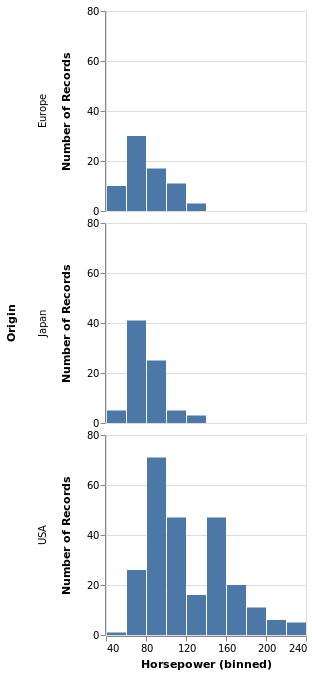

In [15]:
trellisBarHistogram =
    let dvals = dataFromUrl "data/cars.json" []
        enc = encoding
                . position X [PName "Horsepower", PmType Quantitative, PBin [MaxBins 15]]
                . position Y [PAggregate Count, PmType Quantitative]
                . row [FName "Origin", FmType Nominal]
    
    in toVegaLite [dvals, mark Bar [], enc []]

vlShow trellisBarHistogram

In [16]:
validate trellisBarHistogramSpec trellisBarHistogram

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Trellis Scatter Plot Showing Anscombe's Quartet

From https://vega.github.io/vega-lite/examples/trellis_anscombe.html

In [17]:
trellisAnscombeSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Anscombe's Quartet",
  "data": {"url": "data/anscombe.json"},
  "mark": "circle",
  "encoding": {
    "column": {"field": "Series", "type": "nominal"},
    "x": {
      "field": "X",
      "type": "quantitative",
      "scale": {"zero": false}
    },
    "y": {
      "field": "Y",
      "type": "quantitative",
      "scale": {"zero": false}
    },
    "opacity": {"value": 1}
  }
}
|]

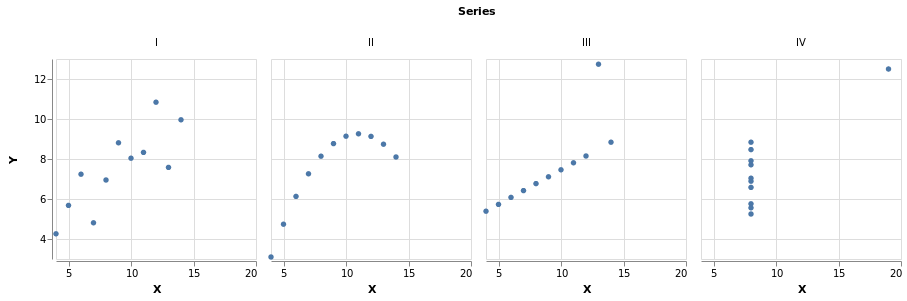

In [18]:
trellisAnscombe =
    let desc = description "Anscombe's Quartet"
        dvals = dataFromUrl "data/anscombe.json" []
        
        enc = encoding
                . column [FName "Series", FmType Nominal]
                . position X [PName "X", PmType Quantitative, PScale [SZero False]]
                . position Y [PName "Y", PmType Quantitative, PScale [SZero False]]
                . opacity [MNumber 1]
                
    in toVegaLite [desc, dvals, mark Circle [], enc []]

vlShow trellisAnscombe

In [19]:
validate trellisAnscombeSpec trellisAnscombe

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Becker's Barley Trellis Plot

From https://vega.github.io/vega-lite/examples/trellis_barley.html

As with the [Trellis Scatter Plot](#Trellis-Scatter-Plot) example, this visualization has to be created slightly-differently
to the example specification.

In [20]:
trellisBarleySpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "name": "trellis_barley",
  "description": "The Trellis display by Becker et al. helped establish small multiples as a “powerful mechanism for understanding interactions in studies of how a response depends on explanatory variables”. Here we reproduce a trellis of Barley yields from the 1930s, complete with main-effects ordering to facilitate comparison.",
  "data": {"url": "data/barley.json"},
  "mark": "point",
  "height": {"step": 12},
  "encoding": {
    "facet": {
      "field": "site",
      "type": "ordinal",
      "columns": 2,
      "sort": {"op": "median", "field": "yield"}
    },
    "x": {
      "aggregate": "median",
      "field": "yield",
      "type": "quantitative",
      "scale": {"zero": false}
    },
    "y": {
      "field": "variety",
      "type": "ordinal",
      "sort": "-x"
    },
    "color": {"field": "year", "type": "nominal"}
  }
}
|]

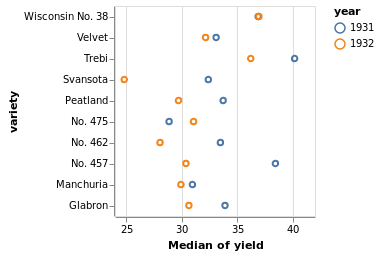

In [21]:
trellisBarley =
    let desc = "The Trellis display by Becker et al. helped establish small multiples as a " <>
               "“powerful mechanism for understanding interactions in studies of how a response " <>
               "depends on explanatory variables”. Here we reproduce a trellis of Barley yields " <>
               "from the 1930s, complete with main-effects ordering to facilitate comparison."
        dvals = dataFromUrl "data/barley.json"
        markOpts = mark Point []
        
        cols = columns 2
        fct = facetFlow [FName "site", FmType Ordinal, FSort [ByFieldOp "yield" Median]]
        
        enc = encoding
                 . position X [PName "yield", PAggregate Median, PmType Quantitative, PScale [SZero False]]
                 . position Y [PName "variety", PmType Ordinal, PSort [Descending]]
                 . color [MName "year", MmType Nominal]
        
    in toVegaLite [ name "trellis_barley"
                  , description desc
                  , dvals []
                  , cols
                  , fct
                  , specification (asSpec [markOpts, enc []])
                  ]
    
    
vlShow trellisBarley

In [22]:
validate trellisBarleySpec trellisBarley

The visualization and expected specification do not match.

Keys are different:
  Missing: ["encoding","height","mark"]
  Extra  : ["columns","facet","spec"]

The field-level differences are:
2,5d1
<   "height": {
<     "step": 12
<   },
<   "mark": "point",
10,20c6,11
<   "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
<   "encoding": {
<     "color": {
<       "field": "year",
<       "type": "nominal"
<     },
<     "facet": {
<       "field": "site",
<       "sort": {
<         "op": "median",
<         "field": "yield"
---
>   "spec": {
>     "mark": "point",
>     "encoding": {
>       "color": {
>         "field": "year",
>         "type": "nominal"
22,28c13,19
<       "columns": 2,
<       "type": "ordinal"
<     },
<     "x": {
<       "field": "yield",
<       "scale": {
<         "zero": false
---
>       "x": {
>         "field": "yield",
>         "scale": {
>           "zero": false
>         },
>         "aggregate": "median",
>         "type": "quantitativ

Return to the [Table of Contents](#Table-of-Contents).

### Trellis Area

From https://vega.github.io/vega-lite/examples/trellis_area.html

In [23]:
trellisAreaSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Stock prices of four large companies as a small multiples of area charts.",
  "transform": [
      {
          "filter": "datum.symbol !== 'GOOG'"
      }
  ],
  "width": 300,
  "height": 40,
  "data": {
      "url": "data/stocks.csv"
  },
  "mark": "area",
  "encoding": {
      "x": {
          "field": "date",
          "type": "temporal",
          "axis": {
              "title": "Time",
              "grid": false
          }
      },
      "y": {
          "field": "price",
          "type": "quantitative",
          "axis": {
              "title": "Price",
              "grid": false
          }
      },
      "color": {
          "field": "symbol",
          "type": "nominal",
          "legend": null
      },
      "row": {
          "field": "symbol",
          "type": "nominal",
          "header": {"title": "Symbol"}
      }
  }
}
|]

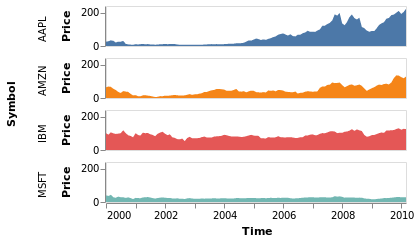

In [24]:
trellisArea =
    let desc = "Stock prices of four large companies as a small multiples of area charts."
    
        xEnc = position X [PName "date", PmType Temporal, PAxis [AxTitle "Time", AxGrid False]]
        yEnc = position Y [PName "price", PmType Quantitative, PAxis [AxTitle "Price", AxGrid False]]
        cEnc = color [MName "symbol", MmType Nominal, MLegend []]
        rEnc = row [FName "symbol", FmType Nominal, FHeader [HTitle "Symbol"]]
        
    in toVegaLite [ description desc
                  , transform (filter (FExpr "datum.symbol !== 'GOOG'") [])
                  , width 300
                  , height 40
                  , dataFromUrl "data/stocks.csv" []
                  , mark Area []
                  , encoding . xEnc . yEnc . cEnc . rEnc $ []
                  ]
    
vlShow trellisArea

In [25]:
validate trellisAreaSpec trellisArea

Okay

Return to the [Table of Contents](#Table-of-Contents).

-----
 
## Repeat and Concatenation

 - [Repeat and Layer to Show Different Weather Measures](#Repeat-and-Layer-to-Show-Different-Weather-Measures)
 - [Vertical Concatenation](#Vertical-Concatenation)
 - [Horizontally Repeated Charts](#Horizontally-Repeated-Charts)
 - Interactive Scatterplot Matrix (repeat of version in the Interactive notebook)
 - [Marginal Histograms](#Marginal-Histograms)
 - [Discretizing Scales](#Discretizing-Scales)
 - [Nested View Concatenation Aligned with Axis minExtent](#Nested-View-Concatenation-Aligned-with-Axis-minExtent)
 - [Population Pyramid](#Population-Pyramid)

---

### Repeat and Layer to Show Different Weather Measures

From https://vega.github.io/vega-lite/examples/repeat_layer.html

In [26]:
repeatLayerSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Summarized and per year weather information for Seatle and New York.",
  "data": {"url": "data/weather.csv"},
  "repeat": {"column": ["temp_max", "precipitation", "wind"]},
  "spec": {
    "layer": [
      {
        "mark": "line",
        "encoding": {
          "y": {
            "aggregate": "mean",
            "field": {"repeat": "column"},
            "type": "quantitative"
          },
          "x": {
            "timeUnit": "month",
            "field": "date",
            "type": "ordinal"
          },
          "detail": {
            "timeUnit": "year",
            "type": "temporal",
            "field": "date"
          },
          "color": {"type": "nominal", "field": "location"},
          "opacity": {"value": 0.2}
        }
      },
      {
        "mark": "line",
        "encoding": {
          "y": {
            "aggregate": "mean",
            "field": {"repeat": "column"},
            "type": "quantitative"
          },
          "x": {
            "timeUnit": "month",
            "field": "date",
            "type": "ordinal"
          },
          "color": {"type": "nominal", "field": "location"}
        }
      }
    ]
  }
}
|]

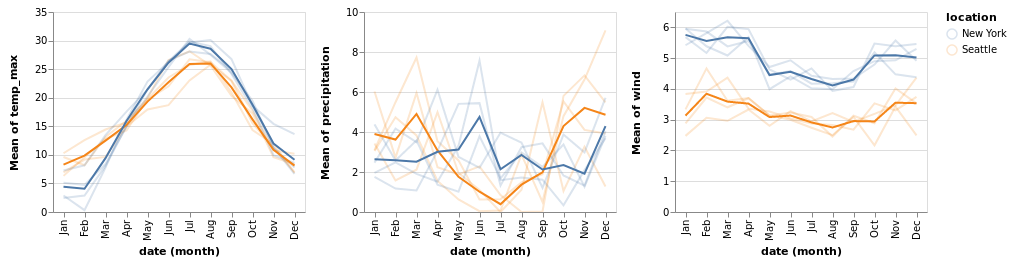

In [27]:
repeatLayer =
    let desc = "Summarized and per year weather information for Seatle and New York."
    
        lineOpts = mark Line []
        
        baseEnc = encoding
                     . position X [PName "date", PmType Ordinal, PTimeUnit Month]
                     . position Y [PAggregate Mean, PmType Quantitative, PRepeat Column]
                     . color [MName "location", MmType Nominal]
                     
        extraEnc = detail [DName "date", DmType Temporal, DTimeUnit Year]
                   . opacity [MNumber 0.2]
        
        byYear = [lineOpts, (baseEnc . extraEnc) []]
        combined = [lineOpts, baseEnc []]
        
        specs = layer (map asSpec [byYear, combined])
        
    in toVegaLite [ description desc, dataFromUrl "data/weather.csv" []
                  , repeat [ColumnFields ["temp_max", "precipitation", "wind"]]
                  , specification (asSpec [specs])
                  ]
    
vlShow repeatLayer

In [28]:
validate repeatLayerSpec repeatLayer

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Vertical Concatenation

From https://vega.github.io/vega-lite/examples/vconcat_weather.html

In [29]:
vconcatWeatherSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Two vertically concatenated charts that show a histogram of precipitation in Seattle and the relationship between min and max temperature.",
  "data": {
    "url": "data/weather.csv"
  },
  "transform": [{
    "filter": "datum.location === 'Seattle'"
  }],
  "vconcat": [
    {
      "mark": "bar",
      "encoding": {
        "x": {
          "timeUnit": "month",
          "field": "date",
          "type": "ordinal"
        },
        "y": {
          "aggregate": "mean",
          "field": "precipitation",
          "type": "quantitative"
        }
      }
    },
    {
      "mark": "point",
      "encoding": {
        "x": {
          "field": "temp_min",
          "type": "quantitative",
          "bin": true
        },
        "y": {
          "field": "temp_max",
          "type": "quantitative",
          "bin": true
        },
        "size": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
  ]
}
|]

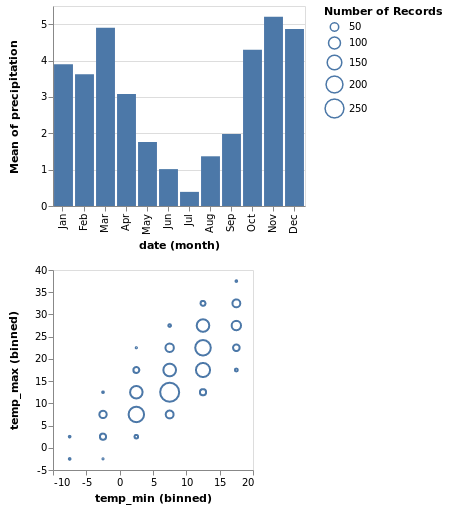

In [30]:
vconcatWeather =
    let desc = "Two vertically concatenated charts that show a histogram of precipitation in Seattle and the relationship between min and max temperature."
    
        encRain = encoding
                    . position X [PName "date", PmType Ordinal, PTimeUnit Month]
                    . position Y [PName "precipitation", PmType Quantitative, PAggregate Mean]
                    
        encTemp = encoding
                    . position X [PName "temp_min", PmType Quantitative, PBin []]
                    . position Y [PName "temp_max", PmType Quantitative, PBin []]
                    . size [MAggregate Count, MmType Quantitative]
                    
        rain = [mark Bar [], encRain []]
        temp = [mark Point [], encTemp []]
        plots = map asSpec [rain, temp]
        
    in toVegaLite [ description desc
                  , dataFromUrl "data/weather.csv" []
                  , transform . filter (FExpr "datum.location === 'Seattle'") $ []
                  , vConcat plots
                  ]

vlShow vconcatWeather

In [31]:
validate vconcatWeatherSpec vconcatWeather

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Horizontally Repeated Charts

From https://vega.github.io/vega-lite/examples/repeat_histogram.html

In [32]:
repeatHistogramSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "repeat": ["Horsepower", "Miles_per_Gallon", "Acceleration", "Displacement"],
  "columns": 2,
  "spec": {
    "data": {"url": "data/cars.json"},
    "mark": "bar",
    "encoding": {
      "x": {
        "field": {"repeat": "repeat"},
        "bin": true,
        "type": "quantitative"
      },
      "y": {"aggregate": "count", "type": "quantitative"},
      "color": {"field": "Origin", "type": "nominal"}
    }
  }
}
|]

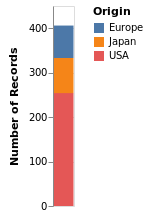

In [33]:
repeatHistogram =
    let cols = ["Horsepower", "Miles_per_Gallon", "Acceleration", "Displacement"]
    
        enc = encoding
                . position X [PRepeat Flow, PBin [], PmType Quantitative]
                . position Y [PAggregate Count, PmType Quantitative]
                . color [MName "Origin", MmType Nominal]
                
        plot = [ dataFromUrl "data/cars.json" []
               , mark Bar []
               , enc []
               ]
    in toVegaLite [ repeatFlow cols
                  , columns 2
                  , specification (asSpec plot)
                  ]
                  
vlShow repeatHistogram

In [34]:
validate repeatHistogramSpec repeatHistogram

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Marginal Histograms

From https://vega.github.io/vega-lite/examples/concat_marginal_histograms.html

In [35]:
concatMarginalHistogramsSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/movies.json"},
  "spacing": 15,
  "bounds": "flush",
  "vconcat": [{
    "mark": "bar",
    "height": 60,
    "encoding": {
      "x": {
        "bin": true,
        "field": "IMDB_Rating",
        "type": "quantitative",
        "axis": null
      },
      "y": {
        "aggregate": "count",
        "type": "quantitative",
        "scale": {
          "domain": [0,1000]
        },
        "title": ""
      }
    }
  }, {
    "spacing": 15,
    "bounds": "flush",
    "hconcat": [{
      "mark": "rect",
      "encoding": {
        "x": {
          "bin": true,
          "field": "IMDB_Rating",
          "type": "quantitative"
        },
        "y": {
          "bin": true,
          "field": "Rotten_Tomatoes_Rating",
          "type": "quantitative"
        },
        "color": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }, {
      "mark": "bar",
      "width": 60,
      "encoding": {
        "y": {
          "bin": true,
          "field": "Rotten_Tomatoes_Rating",
          "type": "quantitative",
          "axis": null
        },
        "x": {
          "aggregate": "count",
          "type": "quantitative",
          "scale": {
            "domain": [0,1000]
          },
          "title": ""
        }
      }
    }]
  }],
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
}
|]

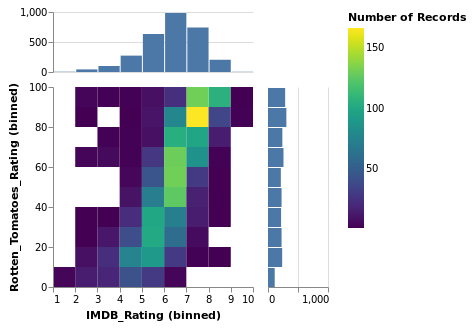

In [36]:
concatMarginalHistograms =
    let plotBounds = bounds Flush
        plotSpacing = spacing 15
    
        binAxis dir name extra = position dir ([PName name, PmType Quantitative, PBin []] <> extra)
        countAxis dir = position dir [PAggregate Count, PmType Quantitative, PTitle "", PScale [SDomain (DNumbers [0, 1000])]]


        histIMDB = [ mark Bar []
                   , height 60
                   , encoding
                       . binAxis X "IMDB_Rating" [PAxis []]
                       . countAxis Y
                       $ []
                       
                   ]
        histRT = [ mark Bar []
                 , width 60
                 , encoding
                      . binAxis Y "Rotten_Tomatoes_Rating" [PAxis []]
                      . countAxis X
                      $ []
                 ]

        mainPlot = [ mark Rect []
                   , encoding
                       . binAxis X "IMDB_Rating" []
                       . binAxis Y "Rotten_Tomatoes_Rating" []
                       . color [MAggregate Count, MmType Quantitative]
                       $ []
                   ]
        
        hPlots = map asSpec [mainPlot, histRT]
        
        plots = map asSpec [histIMDB, [plotSpacing, plotBounds, hConcat hPlots]]
    
    in toVegaLite [ dataFromUrl "data/movies.json" []
                  , plotBounds
                  , plotSpacing
                  , vConcat plots
                  , configure (configuration (View [ViewStroke (Just "transparent")]) [])
                  ]

vlShow concatMarginalHistograms

In [37]:
validate concatMarginalHistogramsSpec concatMarginalHistograms

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Discretizing Scales

From https://vega.github.io/vega-lite/examples/concat_bar_scales_discretize.html

In [38]:
concatBarScalesDiscretizeSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Horizontally concatenated charts that show different types of discretizing scales.",
  "data": {
    "values": [
      {"a": "A", "b": 28},
      {"a": "B", "b": 55},
      {"a": "C", "b": 43},
      {"a": "D", "b": 91},
      {"a": "E", "b": 81},
      {"a": "F", "b": 53},
      {"a": "G", "b": 19},
      {"a": "H", "b": 87},
      {"a": "I", "b": 52}
    ]
  },
  "hconcat": [
    {
      "mark": "circle",
      "encoding": {
        "y": {
          "field": "b",
          "type": "nominal",
          "sort": null,
          "axis": {
            "ticks": false,
            "domain": false,
            "title": null
          }
        },
        "size": {
          "field": "b",
          "type": "quantitative",
          "scale": {
            "type": "quantize"
          }
        },
        "color": {
          "field": "b",
          "type": "quantitative",
          "scale": {
            "type": "quantize",
            "zero": true
          },
          "legend": {
            "title": "Quantize"
          }
        }
      }
    },
    {
      "mark": "circle",
      "encoding": {
        "y": {
          "field": "b",
          "type": "nominal",
          "sort": null,
          "axis": {
            "ticks": false,
            "domain": false,
            "title": null
          }
        },
        "size": {
          "field": "b",
          "type": "quantitative",
          "scale": {
            "type": "quantile",
            "range": [80, 160, 240, 320, 400]
          }
        },
        "color": {
          "field": "b",
          "type": "quantitative",
          "scale": {
            "type": "quantile",
            "scheme": "magma"
          },
          "legend": {
            "format": "d",
            "title": "Quantile"
          }
        }
      }
    },
    {
      "mark": "circle",
      "encoding": {
        "y": {
          "field": "b",
          "type": "nominal",
          "sort": null,
          "axis": {
            "ticks": false,
            "domain": false,
            "title": null
          }
        },
        "size": {
          "field": "b",
          "type": "quantitative",
          "scale": {
            "type": "threshold",
            "domain": [30, 70],
            "range": [80, 200, 320]
          }
        },
        "color": {
          "field": "b",
          "type": "quantitative",
          "scale": {
            "type": "threshold",
            "domain": [30, 70],
            "scheme": "viridis"
          },
          "legend": {
            "title": "Threshold"
          }
        }
      }
    }
  ],
  "resolve": {
    "scale": {
      "color": "independent",
      "size": "independent"
    }
  }
}
|]

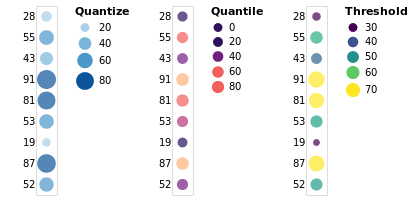

In [39]:
concatBarScalesDiscretize =
    let dvals = dataFromColumns []
                  . dataColumn "a" (Strings ["A", "B", "C", "D", "E", "F", "G", "H", "I"])
                  . dataColumn "b" (Numbers [28, 55, 43, 91, 81, 53, 19, 87, 52])


        yEnc = position Y [PName "b", PmType Nominal, PSort [], PAxis [AxTicks False, AxDomain False, AxNoTitle]]

        sizeEnc stype sextra = size [MName "b", MmType Quantitative, MScale ([SType stype] <> sextra)]
        
        colorEnc title stype sextra lextra =
            color [ MName "b"
                  , MmType Quantitative
                  , MScale ([SType stype] <> sextra)
                  , MLegend ([LTitle title] <> lextra)
                               ]

        quantize = [ mark Circle []
                   , encoding
                       . yEnc
                       . sizeEnc ScQuantize []
                       . colorEnc "Quantize" ScQuantize [SZero True] []
                       $ []
                   ]
        quantile = [ mark Circle []
                   , encoding
                       . yEnc
                       . sizeEnc ScQuantile [SRange (RNumbers [80, 160, 240, 320, 400])]
                       . colorEnc "Quantile" ScQuantile [SScheme "magma" []] [LFormat "d"]
                       $ []
                   ]
        threshold = [ mark Circle []
                    , encoding
                        . yEnc
                        . sizeEnc ScThreshold [ SDomain (DNumbers [30, 70])
                                              , SRange (RNumbers [80, 200, 320])
                                              ]
                        . colorEnc "Threshold" ScThreshold [SScheme "viridis" [], SDomain (DNumbers [30, 70])] []
                        $ []
                    ]

        plots = map asSpec [quantize, quantile, threshold]
        
    in toVegaLite [ description "Horizontally concatenated charts that show different types of discretizing scales."
                  , dvals []
                  , hConcat plots
                  , resolve (resolution (RScale [(ChColor, Independent), (ChSize, Independent)]) [])
                  ]

vlShow concatBarScalesDiscretize

In [40]:
validate concatBarScalesDiscretizeSpec concatBarScalesDiscretize

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Nested View Concatenation Aligned with Axis minExtent

From https://vega.github.io/vega-lite/examples/nested_concat_align.html

In [41]:
nestedConcatAlignSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Nested concatenation aligned by setting axis minExtent",
  "data": {
    "url": "data/movies.json"
  },
  "vconcat": [{
    "title": "Ratings",
    "repeat": {"column": ["Rotten_Tomatoes_Rating", "IMDB_Rating"]},
    "spec": {
      "width": 150,
      "height": 50,
      "mark": "bar",
      "encoding": {
        "x": {
          "field": {"repeat": "column"},
          "bin": {"maxbins": 20},
          "type": "quantitative"
        },
        "y": {"aggregate": "count", "type": "quantitative"}
      }
    }
  },{
    "title": "Gross",
    "repeat": {"column": ["US_Gross", "Worldwide_Gross"]},
    "spec": {
      "width": 150,
      "height": 50,
      "encoding": {
        "x": {
          "field": {"repeat": "column"},
          "bin": {"maxbins": 20},
          "type": "quantitative"
        },
        "y": {"aggregate": "count", "type": "quantitative"}
      },
      "mark": "bar"
    }
  }],
  "config": {
    "countTitle": "Count",
    "axisX": {"titleLimit": 150},
    "axisY": {
      "minExtent": 40
    }
  }
}
|]

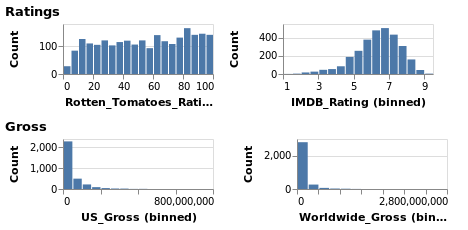

In [42]:
nestedConcatAlign =
    let enc = encoding
                . position X [PRepeat Column, PBin [MaxBins 20], PmType Quantitative]
                . position Y [PAggregate Count, PmType Quantitative]
    
        rspec = [ width 150
                , height 50
                , mark Bar []
                , enc []
                ]
        ratings = [ title "Ratings" []
                  , repeat [ColumnFields ["Rotten_Tomatoes_Rating", "IMDB_Rating"]]
                  , specification (asSpec rspec)
                  ]
        
        gspec = [ width 150
                , height 50
                , mark Bar []
                , enc []
                ]
        gross = [ title "Gross" []
                , repeat [ColumnFields ["US_Gross", "Worldwide_Gross"]]
                , specification (asSpec gspec)
                ]
        
        plots = map asSpec [ratings, gross]
        
        conf = configure
                 . configuration (CountTitle "Count")
                 . configuration (AxisX [TitleLimit 150])
                 . configuration (AxisY [MinExtent 40])
                
    in toVegaLite [ description "Nested concatenation aligned by setting axis minExtent"
                  , dataFromUrl "data/movies.json" []
                  , vConcat plots
                  , conf []
                  ]

vlShow nestedConcatAlign

In [43]:
validate nestedConcatAlignSpec nestedConcatAlign

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Population Pyramid

From https://vega.github.io/vega-lite/examples/concat_population_pyramid.html

In [44]:
concatPopulationPyramidSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "A population pyramid for the US in 2000.",
  "data": { "url": "data/population.json"},
  "transform": [
    {"filter": "datum.year == 2000"},
    {"calculate": "datum.sex == 2 ? 'Female' : 'Male'", "as": "gender"}
  ],
  "spacing": 0,
  "hconcat": [{
    "transform": [{
      "filter": {"field": "gender", "equal": "Female"}
    }],
    "title": "Female",
    "mark": "bar",
    "encoding": {
      "y": {
        "field": "age", "type": "ordinal",
        "axis": null, "sort": "descending"
      },
      "x": {
        "aggregate": "sum", "field": "people", "type": "quantitative",
        "axis": {"title": "population", "format": "s"},
        "sort": "descending"
      },
      "color": {
        "field": "gender", "type": "nominal",
        "scale": {"range": ["#e377c2", "#1f77b4"]},
        "legend": null
      }
    }
  }, {
    "width": 20,
    "view": {"stroke": null},
    "mark": {
      "type": "text",
      "align": "center"
    },
    "encoding": {
      "y": {"field": "age", "type": "ordinal", "axis": null, "sort": "descending"},
      "text": {"field": "age", "type": "quantitative"}
    }
  }, {
    "transform": [{
      "filter": {"field": "gender", "equal": "Male"}
    }],
    "title": "Male",
    "mark": "bar",
    "encoding": {
      "y": {
        "field": "age", "type": "ordinal", "title": null,
        "axis": null, "sort": "descending"
      },
      "x": {
        "aggregate": "sum", "field": "people", "type": "quantitative",
        "axis": {"title": "population", "format": "s"}
      },
      "color": {
        "field": "gender", "type": "nominal",
        "legend": null
      }
    }
  }],
  "config": {
    "view": {"stroke": null},
    "axis": {"grid": false}
  }
}
|]

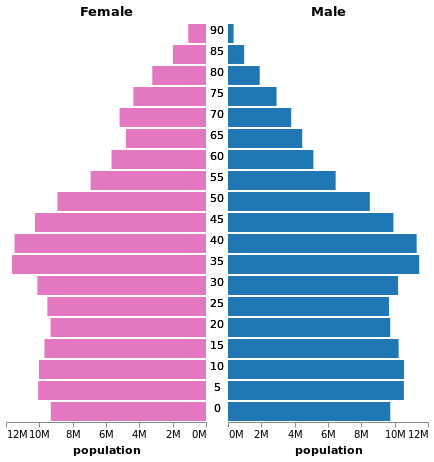

In [45]:
concatPopulationPyramid =
    let genderFilter gender = transform (filter (FEqual "gender" (Str gender)) [])
        
        yPos extra = position Y ([PName "age", PmType Ordinal, PAxis [], PSort [Descending]] <> extra)
        
        plot gender = [ genderFilter gender
                      , title gender []
                      , mark Bar []
                      , encoding
                          . yPos [PNoTitle | gender == "Male"]
                          . position X
                                     ([PAggregate Sum, PName "people", PmType Quantitative, PAxis [AxTitle "population", AxFormat "s"]]
                                      <> [PSort [Descending] | gender == "Female"])
                          . color ([MName "gender", MmType Nominal, MLegend []]
                                   <> [MScale [SRange (RStrings ["#e377c2", "#1f77b4"])] | gender == "Female"])
                          $ []
                      ]
                      
        labelPlot = [ width 20
                    , viewBackground [VBStroke Nothing]
                    , mark Text [MAlign AlignCenter]
                    , encoding
                        . yPos []
                        . text [TName "age", TmType Quantitative]
                        $ []
                    ]
        plots = map asSpec [plot "Female", labelPlot, plot "Male"]
    
    in toVegaLite [ description "A population pyramid for the US in 2000."
                  , dataFromUrl "data/population.json" []
                  , transform 
                      . filter (FExpr "datum.year == 2000")
                      . calculateAs "datum.sex == 2 ? 'Female' : 'Male'" "gender"
                      $ []
                  , spacing 0
                  , hConcat plots
                  , configure
                      . configuration (View [ViewStroke Nothing])
                      . configuration (Axis [Grid False])
                      $ []
                  ]

vlShow concatPopulationPyramid

In [46]:
validate concatPopulationPyramidSpec concatPopulationPyramid

Okay

Return to the [Table of Contents](#Table-of-Contents).